In [74]:
import pandas as pd  # type: ignore
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [75]:
# Load Data
malData = pd.read_csv("/MalwareData.csv.gz", sep="|")
legit = malData[0:41323].drop(["legitimate"], axis=1)
mal = malData[41323::].drop(["legitimate"], axis=1)

print("The shape of the legit dataset: %s samples, %s features" % (legit.shape[0], legit.shape[1]))
print("The shape of malware dataset: %s samples, %s features" % (mal.shape[0], mal.shape[1]))


The shape of the legit dataset: 41323 samples, 56 features
The shape of malware dataset: 96724 samples, 56 features


In [76]:
# Preview Data
pd.set_option("display.max_columns", None)
print(malData.head(5))
print(legit.take([1]))
print(mal.take([1]))


           Name                               md5  Machine  \
0   memtest.exe  631ea355665f28d4707448e442fbf5b8      332   
1       ose.exe  9d10f99a6712e28f8acd5641e3a7ea6b      332   
2     setup.exe  4d92f518527353c0db88a70fddcfd390      332   
3      DW20.EXE  a41e524f8d45f0074fd07805ff0c9b12      332   
4  dwtrig20.exe  c87e561258f2f8650cef999bf643a731      332   

   SizeOfOptionalHeader  Characteristics  MajorLinkerVersion  \
0                   224              258                   9   
1                   224             3330                   9   
2                   224             3330                   9   
3                   224              258                   9   
4                   224              258                   9   

   MinorLinkerVersion  SizeOfCode  SizeOfInitializedData  \
0                   0      361984                 115712   
1                   0      130560                  19968   
2                   0      517120                 621568   
3 

In [77]:
# Prepare data and labels
data_in = malData.drop(['Name', 'md5', 'legitimate'], axis=1).values
labels = malData['legitimate'].values


In [78]:
# Feature Selection
extratrees = ExtraTreesClassifier().fit(data_in, labels)
select = SelectFromModel(extratrees, prefit=True)
data_in_new = select.transform(data_in)
print("Original shape:", data_in.shape)
print("New shape after feature selection:", data_in_new.shape)

Original shape: (138047, 54)
New shape after feature selection: (138047, 13)


In [79]:
# Feature Ranking
importances = extratrees.feature_importances_
indices = np.argsort(importances)[::-1]
features = data_in_new.shape[1]

print("\nTop Features:")
for f in range(features):
    print("%d. %s (%f)" % (f + 1, malData.columns[2 + indices[f]], importances[indices[f]]))



Top Features:
1. DllCharacteristics (0.151573)
2. Machine (0.117725)
3. Characteristics (0.094049)
4. Subsystem (0.058023)
5. ImageBase (0.053983)
6. VersionInformationSize (0.052299)
7. SectionsMaxEntropy (0.052040)
8. ResourcesMaxEntropy (0.050279)
9. MajorSubsystemVersion (0.048627)
10. ResourcesMinEntropy (0.044039)
11. SizeOfOptionalHeader (0.040074)
12. MajorOperatingSystemVersion (0.024196)
13. SectionsMeanEntropy (0.020681)


In [80]:
# Train/Test Split
legit_train, legit_test, mal_train, mal_test = train_test_split(data_in_new, labels, test_size=0.2, random_state=42)

In [81]:
# Model 1: Random Forest
classif = RandomForestClassifier(n_estimators=50, random_state=42)
classif.fit(legit_train, mal_train)
rf_score = classif.score(legit_test, mal_test) * 100
print("\nRandom Forest Accuracy: %.2f%%" % rf_score)


Random Forest Accuracy: 99.43%


In [82]:
# Evaluation
result = classif.predict(legit_test)
conf_mat = confusion_matrix(mal_test, result)
print("Confusion Matrix:\n", conf_mat)
print("False Positives: %.2f%%" % (conf_mat[0][1] / sum(conf_mat[0]) * 100))
print("False Negatives: %.2f%%" % (conf_mat[1][0] / sum(conf_mat[1]) * 100))
print("\nClassification Report:\n", classification_report(mal_test, result))
print("ROC AUC Score: %.2f" % roc_auc_score(mal_test, result))

Confusion Matrix:
 [[19153    97]
 [   60  8300]]
False Positives: 0.50%
False Negatives: 0.72%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     19250
           1       0.99      0.99      0.99      8360

    accuracy                           0.99     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       0.99      0.99      0.99     27610

ROC AUC Score: 0.99


In [83]:
# Model 2: Gradient Boosting
grad_boost = GradientBoostingClassifier(n_estimators=50, random_state=42)
grad_boost.fit(legit_train, mal_train)
gb_score = grad_boost.score(legit_test, mal_test) * 100
print("\nGradient Boosting Accuracy: %.2f%%" % gb_score)


Gradient Boosting Accuracy: 98.83%


In [84]:
# Model 3: XGBoost
xgb = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(legit_train, mal_train)
xgb_score = xgb.score(legit_test, mal_test) * 100
print("\nXGBoost Accuracy: %.2f%%" % xgb_score)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:43:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 99.28%


In [85]:
# Model 4: Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(legit_train, mal_train)
dt_score = dt.score(legit_test, mal_test) * 100
print("\nDecision Tree Accuracy: %.2f%%" % dt_score)


Decision Tree Accuracy: 99.08%


In [86]:
# Model 5: Naive Bayes
nb = GaussianNB()
nb.fit(legit_train, mal_train)
nb_score = nb.score(legit_test, mal_test) * 100
print("\nNaive Bayes Accuracy: %.2f%%" % nb_score)


Naive Bayes Accuracy: 69.72%


In [87]:
# Model 6: Support Vector Machine
svm = SVC()
svm.fit(legit_train, mal_train)
svm_score = svm.score(legit_test, mal_test) * 100
print("\nSVM Accuracy: %.2f%%" % svm_score)


SVM Accuracy: 69.72%


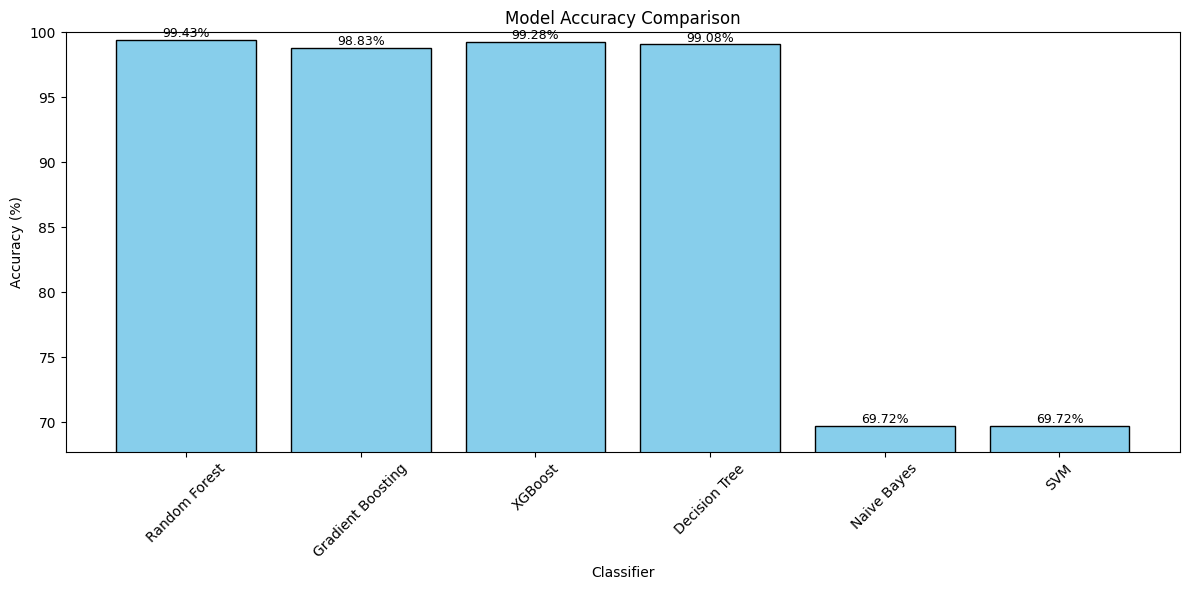

In [88]:
# Accuracy comparison plot
model_names = ["Random Forest", "Gradient Boosting", "XGBoost", "Decision Tree", "Naive Bayes", "SVM"]
model_scores = [rf_score, gb_score, xgb_score, dt_score, nb_score, svm_score]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, model_scores, color='skyblue', edgecolor='black')
plt.xlabel("Classifier")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(min(model_scores) - 2, 100)
for bar, score in zip(bars, model_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f"{score:.2f}%", ha='center', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

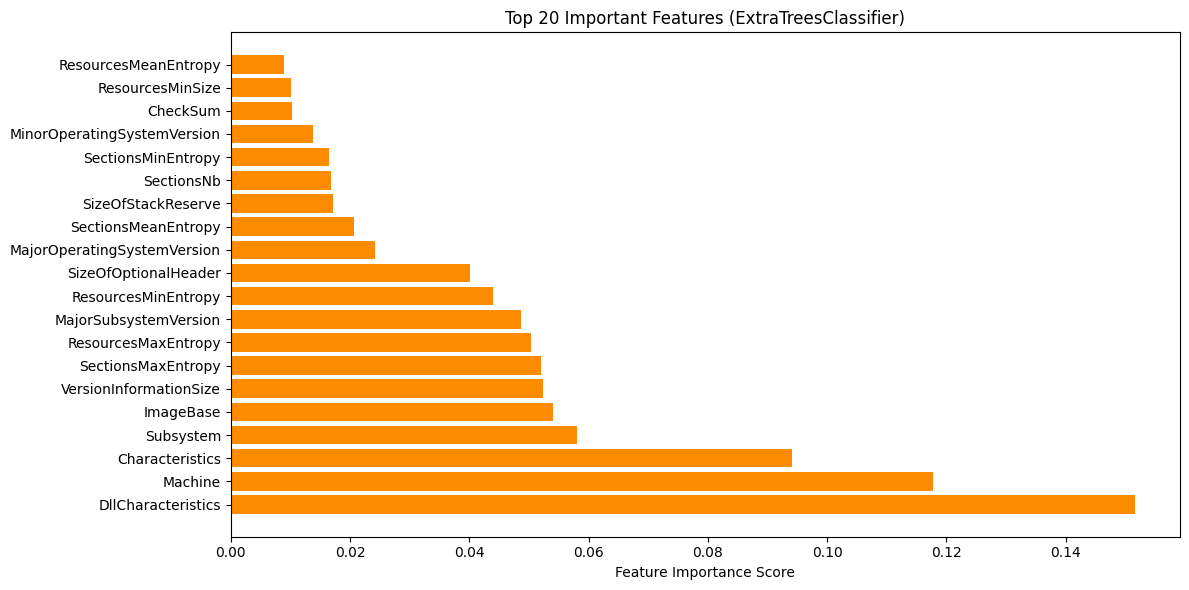

In [89]:
# Feature importance plot (ExtraTreesClassifier)
top_n = 20
top_features = indices[:top_n]
top_importances = importances[top_features]
feature_names = malData.drop(['Name', 'md5', 'legitimate'], axis=1).columns
top_feature_names = [feature_names[i] for i in top_features]

plt.figure(figsize=(12, 6))
plt.barh(range(top_n), top_importances[::-1], align='center', color='darkorange')
plt.yticks(range(top_n), top_feature_names[::-1])
plt.xlabel("Feature Importance Score")
plt.title("Top 20 Important Features (ExtraTreesClassifier)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

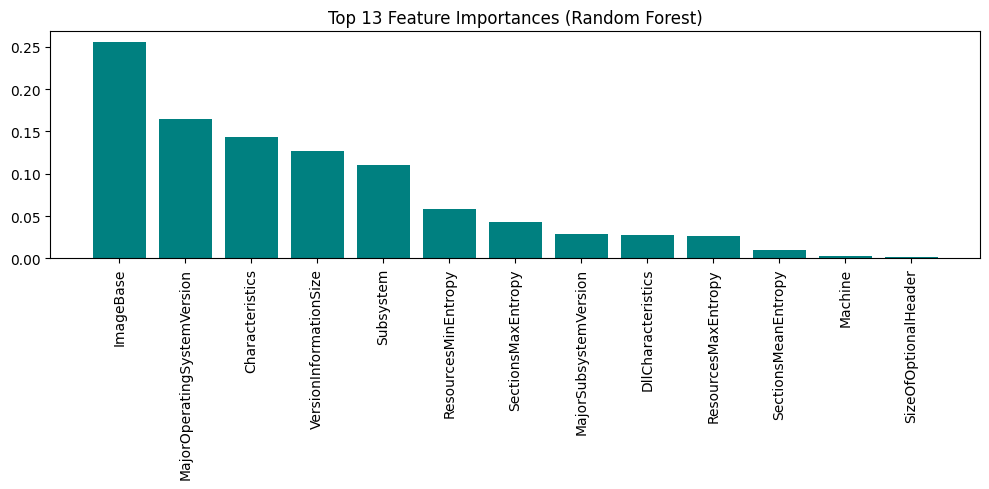

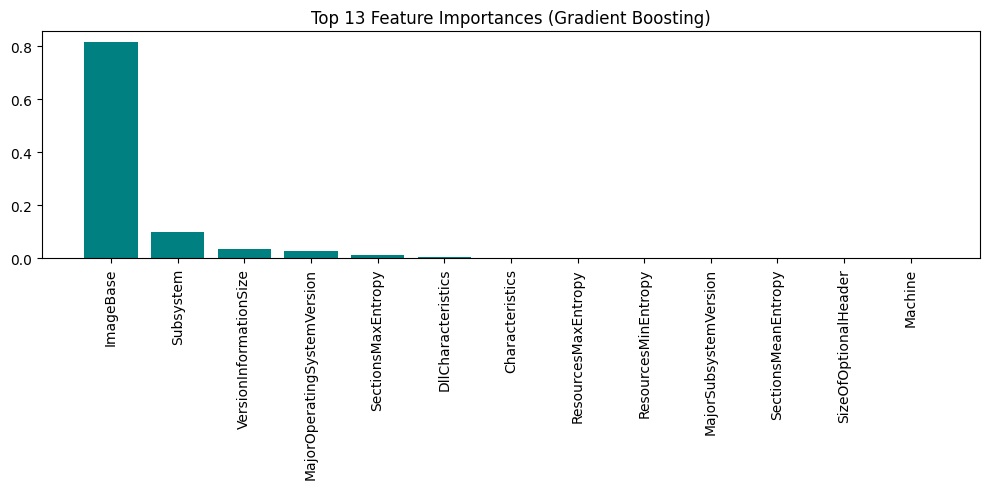

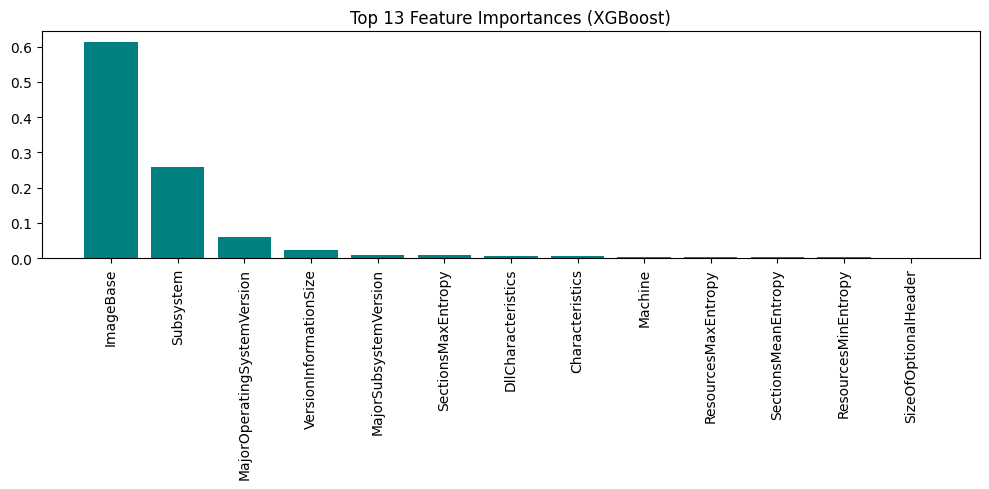

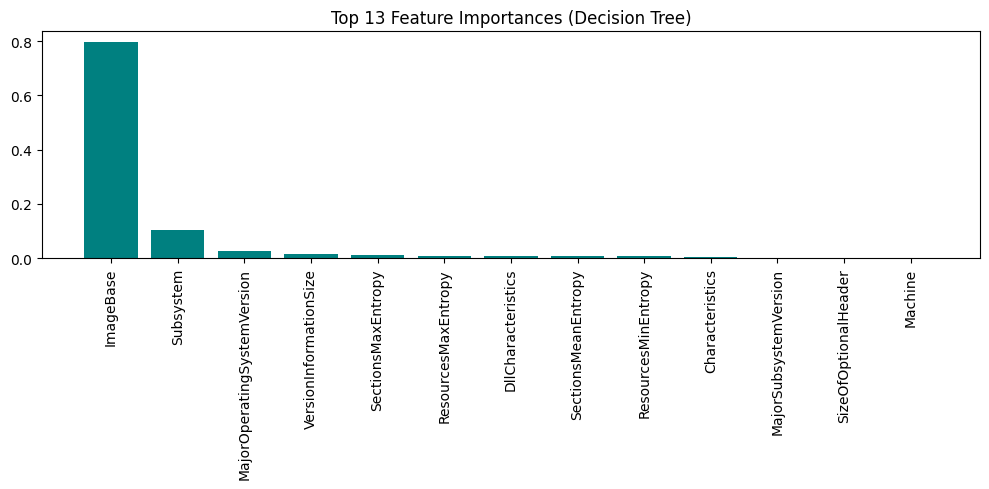

In [93]:
import matplotlib.pyplot as plt

# Set number of top features to plot
top_n = 20

# Tree-based models that support feature_importances_
model_objects = [classif, grad_boost, xgb, dt]
model_labels = ["Random Forest", "Gradient Boosting", "XGBoost", "Decision Tree"]

# Get the correct feature names after feature selection
selected_features = select.get_support(indices=True)
feature_names = malData.drop(['Name', 'md5', 'legitimate'], axis=1).columns[selected_features]

# Plot feature importances
for model, label in zip(model_objects, model_labels):
    importances = model.feature_importances_
    model_top_n = min(top_n, len(importances))
    indices = np.argsort(importances)[::-1][:model_top_n]

    plt.figure(figsize=(10, 5))
    plt.title(f"Top {model_top_n} Feature Importances ({label})")
    plt.bar(range(model_top_n), importances[indices], color='teal', align='center')
    plt.xticks(range(model_top_n), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
